In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.cross_decomposition
import sklearn.neighbors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
current_palette_4 = sns.color_palette("hls", 4)
sns.set_palette(current_palette_4)

In [2]:
## SETUP
sn = 1
setnumber = 'FD00' + str(sn)
pltpath = 'plots/PCA/%s/'%setnumber
## SCALING SETTINGS
bins = [-1, 0.25, 0.5, 0.75, 1.0]
## COMPONENT ANALYSIS SETTINGS
PCA = True
CCA = False
nc = 15
## SVM SETTINGS
outlier_threshold = 0.1

In [3]:
## READ DATA
print 'read data'
train = pd.read_csv('data/train_'+setnumber+'.csv')
train_RULs = np.array([train.loc[train.id==i, 'cycle'].max() for i in train.id.unique()])
test = pd.read_csv('data/test_'+setnumber+'.csv')
test_RULs = np.array([test.loc[test.id==i, 'RUL'].min() for i in train.id.unique()])
#print train

read data


In [4]:
# DROP EXTRA COLUMN(S)
print 'drop index column'
drop_cols = ['Unnamed: 0', 'setting1', 'setting2', 'setting3']#, 's1', 's18', 's19']
train.drop(drop_cols, 1, inplace=True)
test.drop(drop_cols, 1, inplace=True)
#print train

drop index column


In [5]:
## SCALE DATA
scale_separate = True

train_scalables = train.loc[:,train.columns.difference(['id', 'cycle'])].values
test_scalables = test.loc[:,test.columns.difference(['id', 'cycle'])].values
if scale_separate:
    print 'normalize features (using MinMaxScaler) - train and test set are normalized separately!'

    train_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)
    test_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(test_scalables)
    train_values = train_scaler.transform(train_scalables)
    test_values = test_scaler.transform(test_scalables)
else:
    print 'normalize features (using MinMaxScaler) - '
    print 'test set is transformed using the scaler trained on the training set'
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)
    train_values = scaler.transform(train_scalables)
    test_values = scaler.transform(test_scalables)
    
train.loc[:,train.columns.difference(['id', 'cycle'])] = train_values
test.loc[:,test.columns.difference(['id', 'cycle'])] = test_values


print 'bin RUL values'
status_labels = ['urgent', 'short', 'medium', 'long']
train['status'] = pd.cut(train['RUL'], bins, labels=status_labels)
test['status'] = pd.cut(test['RUL'], bins, labels=status_labels)

print 'TRAINING SET\n', train.status.value_counts()
print 'TEST SET\n', test.status.value_counts()

normalize features (using MinMaxScaler) - train and test set are normalized separately!
bin RUL values
TRAINING SET
urgent    9100
short     8362
medium    2823
long       346
Name: status, dtype: int64
TEST SET
short     6193
urgent    5184
medium    1462
long       257
Name: status, dtype: int64


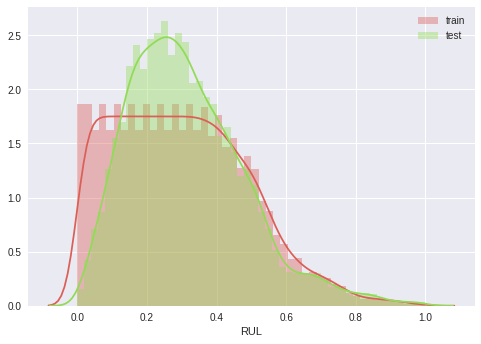

In [6]:
sns.distplot(train.RUL, label='train')
sns.distplot(test.RUL, label='test')
plt.legend()
plt.savefig(pltpath + 'RUL_scaling.png')
plt.show()


In [7]:
## SEPARATE FEATURES AND LABELS
train_X = train.values[:,2:-2]
train_y = train.values[:,-2]
test_X = test.values[:,2:-2]
test_y = test.values[:,-2]


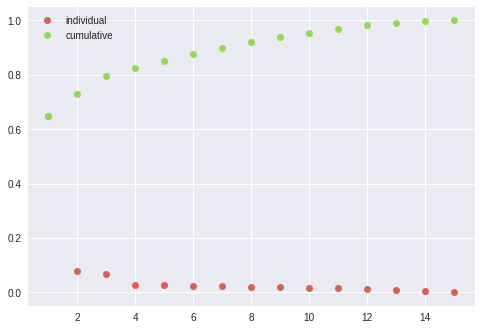

In [8]:
## COMPONENT ANALYSIS

if PCA:
    pca = sklearn.decomposition.PCA(n_components=nc).fit(train_X)
    trainX = pca.transform(train_X)
    testX = pca.transform(test_X)
    evals = pca.explained_variance_ratio_
    evals_cs = evals.cumsum()
    plt.plot(range(1, nc+1), evals, 'o', label='individual')
    plt.plot(range(1, nc+1), evals_cs, 'o', label='cumulative')
    plt.legend()
    plt.savefig(pltpath + 'PCA_variance_ratio.png')
    plt.show()
elif CCA:
    cca = sklearn.cross_decomposition.CCA(n_components=nc).fit(train_X, train_y)
    trainX = cca.transform(train_X)
    testX = cca.transform(test_X)
    

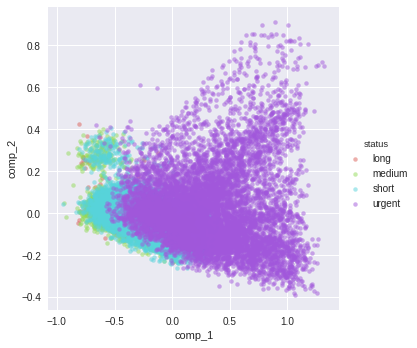

In [9]:
## PLOT SAMPLES ALONG THE FIRST 2 PRINCIPAL COMPONENTS
X_train = pd.DataFrame(trainX, columns=['comp_'+str(x) for x in range(1, trainX.shape[1]+1)])
X_train['status'] = train['status']
X_train.to_csv('data/PCA/train_'+setnumber+'.csv')
X_test = pd.DataFrame(testX, columns=['comp_'+str(x) for x in range(1, testX.shape[1]+1)])
X_test['status'] = test['status']
X_test.to_csv('data/PCA/test_'+setnumber+'.csv')

plt.figure(figsize=(15,15))
sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_train, markers='o', scatter_kws={'alpha':0.5, 's':20})
#sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_test, markers='o', scatter_kws={'alpha':0.5, 's':20})
plt.savefig(pltpath + 'samples_in_PC2.png')
plt.show()


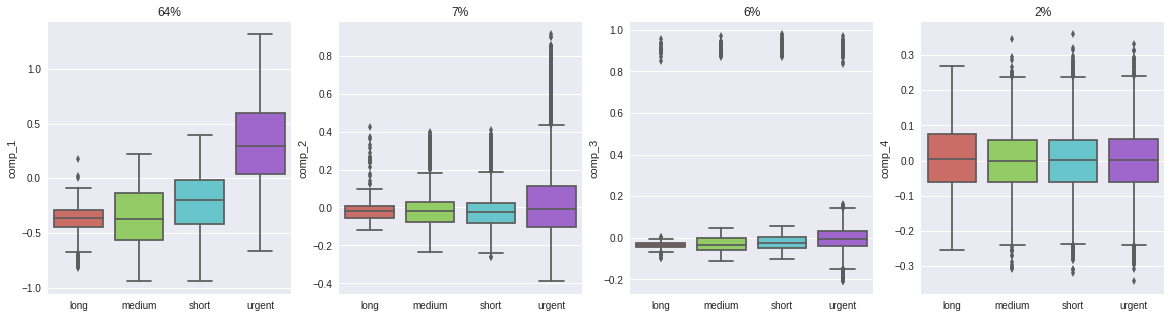

In [10]:
## PLOT DISTRIBUTION OF SAMPLES IN EACH GROUP ALONG THE FIRST 4 COMPONENTS
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs = axs.flatten()
sns.boxplot(x='status', y='comp_1', data=X_train, ax=axs[0])
sns.boxplot(x='status', y='comp_2', data=X_train, ax=axs[1])
sns.boxplot(x='status', y='comp_3', data=X_train, ax=axs[2])
sns.boxplot(x='status', y='comp_4', data=X_train, ax=axs[3])
for i in range(4):
    if PCA:
        axs[i].set_title(str(int(evals[i]*100))+'%')
    axs[i].set_xlabel(' ')
plt.savefig(pltpath + 'sample_distribution_PC4.png')
plt.show()

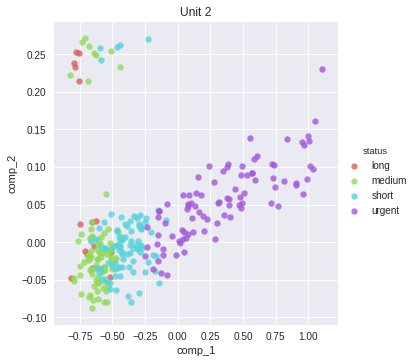

In [11]:
## PLOT TRAJECTORY OF UNIT (i)
i = 2
inds = (train.loc[train.id==i]).index
plt.figure(figsize=(15,15))
sns.lmplot('comp_1', 'comp_2', hue='status', fit_reg=False, data=X_train.iloc[inds], markers='o', scatter_kws={'alpha':0.8, 's':40})
plt.title('Unit %d'%i)
plt.savefig(pltpath + 'trajectory_unit_%d.png'%i)
plt.show()

/home/saghar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/saghar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/saghar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

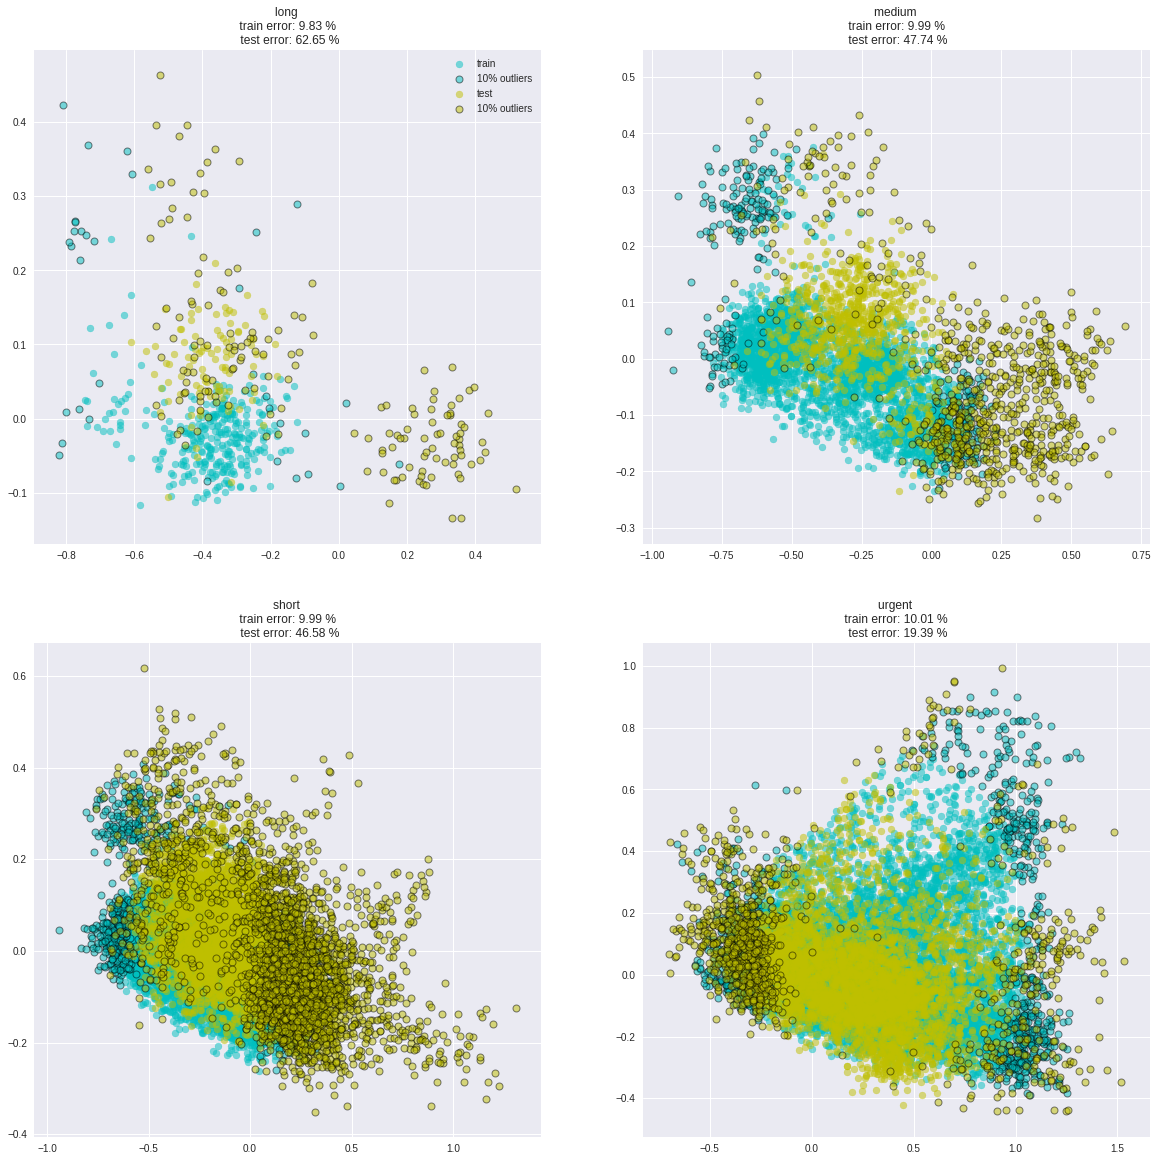

In [12]:
## USE SVM OUTLIER DETECTION
from sklearn import svm
fig, axs = plt.subplots(2,2, figsize=(20,20))
axs = axs.flatten()
for i, reference_status in enumerate(['long', 'medium', 'short', 'urgent']):
    X = X_train.loc[X_train.status==reference_status]
    Xtest = X_test.loc[X_test.status==reference_status]
    X['status'] = 1
    Xtest['status'] = 1
    clf = svm.OneClassSVM(nu=outlier_threshold, kernel="rbf", degree=2).fit(X.values)
    y_pred_train = clf.predict(X)
    y_pred_test = clf.predict(Xtest)
    X['predict'] = y_pred_train
    Xtest['predict'] = y_pred_test
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size

    train_normal = X.loc[X.predict==1]
    train_outlier = X.loc[X.predict==-1]
    test_normal = Xtest.loc[Xtest.predict==1]
    test_outlier = Xtest.loc[Xtest.predict==-1]

    axs[i].scatter(train_normal.comp_1, train_normal.comp_2, 
                   facecolor='c', label='train', alpha=0.5)
    axs[i].scatter(train_outlier.comp_1, train_outlier.comp_2, 
                   facecolor='c', edgecolor='k', lw=1, 
                   label='%d%% outliers'%(outlier_threshold*100.), alpha=0.5)
    axs[i].scatter(test_normal.comp_1, test_normal.comp_2, 
                   facecolor='y', label='test', alpha=0.5)
    axs[i].scatter(test_outlier.comp_1, test_outlier.comp_2, 
                   facecolor='y', edgecolor='k', lw=1, 
                   label='%d%% outliers'%(outlier_threshold*100.), alpha=0.5)

    axs[i].set_title('%s \n train error: %.2f %% \n test error: %.2f %%'%(reference_status, n_error_train*1. / X.shape[0] * 100., n_error_test*1. / Xtest.shape[0] * 100.))

axs[0].legend()
plt.savefig(pltpath + 'outliers_%d_percent.png'%(outlier_threshold*100))
plt.show()